## Otaku Castle Anime Recommender System
Data from Kaggle.com, collected from myanimelist.com

Source: https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset


In [1]:
# Import statements
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn

### Replacing anime images from original location (MAL server) to local host

Due to how many images (over 10,000) - and thus how long running this part will take - I have decided to run the scraping code in a separate notebook named "Pull_Images". This code is available within the repository. It's purpose is to web scrape images, rename the images to what is found in the column 'English name', create img directory and store the downloaded and renamed images then update df_images to new 'Image URL'

That notebook must be run first, but only once, to create an updated csv file with the proper 'Image URL' links in the dataframe.

Once it completes, the images will be uploaded to the webserver and the links within the dataframe and csv file will function. The changes will be made within the current dataframe "anime" and saved to "OC_linked_dataset.csv."

In [2]:
# Options
pd.set_option("display.max_rows", 100)

In [3]:
# Load dataframes
anime_df = pd.read_csv("OC_linked_dataset.csv")
scores_df = pd.read_csv("users-score-2023.csv")
users_df = pd.read_csv("users-details-2023.csv")

In [4]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anime_id      24905 non-null  int64 
 1   Name          24905 non-null  object
 2   English name  24905 non-null  object
 3   Other name    24905 non-null  object
 4   Score         24905 non-null  object
 5   Genres        24905 non-null  object
 6   Synopsis      24905 non-null  object
 7   Type          24905 non-null  object
 8   Episodes      24905 non-null  object
 9   Aired         24905 non-null  object
 10  Premiered     24905 non-null  object
 11  Status        24905 non-null  object
 12  Producers     24905 non-null  object
 13  Licensors     24905 non-null  object
 14  Studios       24905 non-null  object
 15  Source        24905 non-null  object
 16  Duration      24905 non-null  object
 17  Rating        24905 non-null  object
 18  Rank          24905 non-null  object
 19  Popu

In [5]:
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24325191 entries, 0 to 24325190
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 927.9+ MB


In [6]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731290 entries, 0 to 731289
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Mal ID            731290 non-null  int64  
 1   Username          731289 non-null  object 
 2   Gender            224383 non-null  object 
 3   Birthday          168068 non-null  object 
 4   Location          152805 non-null  object 
 5   Joined            731290 non-null  object 
 6   Days Watched      731282 non-null  float64
 7   Mean Score        731282 non-null  float64
 8   Watching          731282 non-null  float64
 9   Completed         731282 non-null  float64
 10  On Hold           731282 non-null  float64
 11  Dropped           731282 non-null  float64
 12  Plan to Watch     731282 non-null  float64
 13  Total Entries     731282 non-null  float64
 14  Rewatched         731282 non-null  float64
 15  Episodes Watched  731282 non-null  float64
dtypes: float64(10), int6

In [7]:
anime_df.head(3)

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://www.otakucastle.com/anime_img/cowboy_b...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://www.otakucastle.com/anime_img/cowboy_b...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://www.otakucastle.com/anime_img/trigun.jpg


In [8]:
scores_df.head(3)

,user_id,Username,anime_id,Anime Title,rating
0,1,Xinil,21,One Piece,9
1,1,Xinil,48,.hack//Sign,7
2,1,Xinil,320,A Kite,5


In [9]:
users_df.head(3)

,Mal ID,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
0,1,Xinil,Male,1985-03-04T00:00:00+00:00,California,2004-11-05T00:00:00+00:00,142.3,7.37,1.0,233.0,8.0,93.0,64.0,399.0,60.0,8458.0
1,3,Aokaado,Male,NaN,"Oslo, Norway",2004-11-11T00:00:00+00:00,68.6,7.34,23.0,137.0,99.0,44.0,40.0,343.0,15.0,4072.0
2,4,Crystal,Female,NaN,"Melbourne, Australia",2004-11-13T00:00:00+00:00,212.8,6.68,16.0,636.0,303.0,0.0,45.0,1000.0,10.0,12781.0


### Dataset preprocessing and cleaning

In [10]:
# Check all dataframes for missing data
anime_df.isna().sum()

anime_id        0
Name            0
English name    0
Other name      0
Score           0
Genres          0
Synopsis        0
Type            0
Episodes        0
Aired           0
Premiered       0
Status          0
Producers       0
Licensors       0
Studios         0
Source          0
Duration        0
Rating          0
Rank            0
Popularity      0
Favorites       0
Scored By       0
Members         0
Image URL       0
dtype: int64

In [11]:
scores_df.isna().sum()

user_id          0
Username       232
anime_id         0
Anime Title      0
rating           0
dtype: int64

In [12]:
users_df.isna().sum()

Mal ID                   0
Username                 1
Gender              506907
Birthday            563222
Location            578485
Joined                   0
Days Watched             8
Mean Score               8
Watching                 8
Completed                8
On Hold                  8
Dropped                  8
Plan to Watch            8
Total Entries            8
Rewatched                8
Episodes Watched         8
dtype: int64

In [13]:
# Users has missing data in 3 columns: Gender, Birthday, and Location. Roughly 2/3 of all records is missing this data, 
# so I will remove those columns from the dataset. 
users_df.drop(columns = ['Gender', 'Birthday', 'Location'], axis = 1, inplace = True)

In [14]:
# The "Joined" column is not helpful, and taking up space/processing time. I will remove it as well.
users_df.drop(columns = ['Joined'], axis = 1, inplace = True)

In [15]:
users_df.isna().sum()

Mal ID              0
Username            1
Days Watched        8
Mean Score          8
Watching            8
Completed           8
On Hold             8
Dropped             8
Plan to Watch       8
Total Entries       8
Rewatched           8
Episodes Watched    8
dtype: int64

In [16]:
# Check unique number of anime titles
anime_df.groupby('anime_id')['Name'].nunique().sum()

24905

In [17]:
# Checking scores in anime dataframe
anime_df['Score'].value_counts()

Score
UNKNOWN    9213
6.31         80
6.54         80
6.25         79
6.51         79
           ... 
3.21          1
3.29          1
1.85          1
3.69          1
4.07          1
Name: count, Length: 567, dtype: int64

Finding 9213 records with an unknown score will cause issues later. To fix this, I have choices. I could give these records a score of 1, delete those rows, or create a mean score from the other records. Before deciding, let's take a look at the data.

In [18]:
# Check for any anime with "Unknown" Score
anime_df.loc[anime_df['Score'] == "UNKNOWN"]

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
1578,1739,Shibawanko no Wa no Kokoro,UNKNOWN,しばわんこの和のこころ,UNKNOWN,UNKNOWN,Based on a japanese children`s book by Yoshie ...,TV,80.0,"Apr 5, 2006 to Mar 14, 2007",...,Three-d,Unknown,2 min per ep,G - All Ages,19660.0,13679,1,UNKNOWN,728,https://www.otakucastle.com/anime_img/unknown.jpg
1699,1863,Silk Road Shounen Yuuto,UNKNOWN,シルクロード少年 ユート,UNKNOWN,"Adventure, Fantasy","When a boy Yuto visits Qinghai in China, he is...",TV,26.0,"Sep 16, 2006 to Mar 24, 2007",...,OLM,Unknown,20 min per ep,UNKNOWN,19912.0,13981,0,UNKNOWN,657,https://www.otakucastle.com/anime_img/unknown.jpg
2476,2701,Susie-chan to Marvy,Little Susie and Marvy,スージーちゃんとマービー,UNKNOWN,Comedy,No description available for this anime.,TV,104.0,"Apr 5, 1999 to Feb 3, 2000",...,Xebec,Unknown,15 min per ep,UNKNOWN,12706.0,16212,0,UNKNOWN,374,https://www.otakucastle.com/anime_img/little_s...
2483,2708,Wankorobee,UNKNOWN,わんころべえ,UNKNOWN,"Comedy, Fantasy",No description available for this anime.,TV,26.0,"Oct 6, 1996 to Mar 30, 1997",...,"Ajia-do, TMS Entertainment",Original,15 min per ep,G - All Ages,13327.0,16545,0,UNKNOWN,348,https://www.otakucastle.com/anime_img/unknown.jpg
2508,2735,Mugen Senki Portriss,UNKNOWN,無限戦記ポトリス,UNKNOWN,"Action, Sci-Fi","In a raving world, legendary knights stood up....",TV,52.0,"Apr 5, 2003 to Mar 27, 2004",...,"Sunrise, Dongwoo A&E",Unknown,25 min per ep,PG - Children,18320.0,14460,1,UNKNOWN,567,https://www.otakucastle.com/anime_img/unknown.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24900,55731,Wu Nao Monu,UNKNOWN,无脑魔女,UNKNOWN,"Comedy, Fantasy, Slice of Life",No description available for this anime.,ONA,15.0,"Jul 4, 2023 to ?",...,UNKNOWN,Web manga,Unknown,PG-13 - Teens 13 or older,UNKNOWN,24723,0,UNKNOWN,0,https://www.otakucastle.com/anime_img/unknown.jpg
24901,55732,Bu Xing Si: Yuan Qi,Blader Soul,捕星司·源起,UNKNOWN,"Action, Adventure, Fantasy",No description available for this anime.,ONA,18.0,"Jul 27, 2023 to ?",...,UNKNOWN,Web novel,Unknown,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0,https://www.otakucastle.com/anime_img/blader_s...
24902,55733,Di Yi Xulie,The First Order,第一序列,UNKNOWN,"Action, Adventure, Fantasy, Sci-Fi",No description available for this anime.,ONA,16.0,"Jul 19, 2023 to ?",...,UNKNOWN,Web novel,Unknown,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0,https://www.otakucastle.com/anime_img/the_firs...
24903,55734,Bokura no Saishuu Sensou,UNKNOWN,僕らの最終戦争,UNKNOWN,UNKNOWN,A music video for the song Bokura no Saishuu S...,Music,1.0,"Apr 23, 2022",...,UNKNOWN,Original,3 min,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0,https://www.otakucastle.com/anime_img/unknown.jpg


Since very few members have watched/favorited these shows with UNKNOWN as a score, I have decided to give them a 0.5 score. This keeps them from being eliminated from the dataset, and maybe allows someone in the future to discover a hidden gem.

In [19]:
anime_df['Score'] = anime_df['Score'].replace('UNKNOWN', '0.5')

In [20]:
# Rerun check to test
anime_df.loc[anime_df['Score'] == "UNKNOWN"]

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL


In [21]:
# Perform same on Rank and Popularity to replace 'UNKNOWN'
anime_df['Rank'] = anime_df['Rank'].replace('UNKNOWN', '0.0')
anime_df['Popularity'] = anime_df['Popularity'].replace('UNKNOWN', '0')

During development of the frontend, I discovered an issue of datatypes for "Rank".  

In [22]:
# Convert 'Rank' to numeric
anime_df['Rank'] = pd.to_numeric(anime_df['Rank'], errors='coerce')

In [23]:
# Check changes
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   anime_id      24905 non-null  int64  
 1   Name          24905 non-null  object 
 2   English name  24905 non-null  object 
 3   Other name    24905 non-null  object 
 4   Score         24905 non-null  object 
 5   Genres        24905 non-null  object 
 6   Synopsis      24905 non-null  object 
 7   Type          24905 non-null  object 
 8   Episodes      24905 non-null  object 
 9   Aired         24905 non-null  object 
 10  Premiered     24905 non-null  object 
 11  Status        24905 non-null  object 
 12  Producers     24905 non-null  object 
 13  Licensors     24905 non-null  object 
 14  Studios       24905 non-null  object 
 15  Source        24905 non-null  object 
 16  Duration      24905 non-null  object 
 17  Rating        24905 non-null  object 
 18  Rank          24905 non-nu

In [24]:
anime_df.loc[anime_df['Rank'] == "NaN"]

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL


Now that corrections and updates have been made to the data, write to new CSV file to be used with all front and backend processing.

In [25]:
anime_df.to_csv('OC_anime_dataset.csv')

The data is clean, and preprocessed. 

Now to dig deeper into the data and possibly create some visualizations that will help in building the Recommender system.

#### CSV File changes to remove unneeded columns

In [26]:
# Remove unneeded columns from two dataframes into new dataframes
clean_anime_df = anime_df[['anime_id', 'English name', 'Genres', 'Synopsis', 'Type', 'Rank', 'Popularity', 'Image URL']].copy()
clean_scores_df = scores_df[['user_id', 'anime_id', 'rating']].copy()

In [27]:
# Export to new CSV for use in Flask (reduces memory load)
clean_anime_df.to_csv('clean_anime.csv')

In [28]:
clean_scores_df.to_csv('clean_scores.csv')

### Data Exploration

This section is not necessary for the model to function, but it will help the creation process to see the data explored both in text and visually.

In [29]:
# Look over scores info
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24325191 entries, 0 to 24325190
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 927.9+ MB


In [30]:
scores_df.head(1)

,user_id,Username,anime_id,Anime Title,rating
0,1,Xinil,21,One Piece,9


In [31]:
# Look over users info
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731290 entries, 0 to 731289
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Mal ID            731290 non-null  int64  
 1   Username          731289 non-null  object 
 2   Days Watched      731282 non-null  float64
 3   Mean Score        731282 non-null  float64
 4   Watching          731282 non-null  float64
 5   Completed         731282 non-null  float64
 6   On Hold           731282 non-null  float64
 7   Dropped           731282 non-null  float64
 8   Plan to Watch     731282 non-null  float64
 9   Total Entries     731282 non-null  float64
 10  Rewatched         731282 non-null  float64
 11  Episodes Watched  731282 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 67.0+ MB


In [32]:
users_df.head(1)

,Mal ID,Username,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
0,1,Xinil,142.3,7.37,1.0,233.0,8.0,93.0,64.0,399.0,60.0,8458.0


In [33]:
# Check unique number of users
users_df.groupby('Mal ID')['Username'].nunique().sum()

731289

In [34]:
# Check unique number of scores
scores_df.groupby('user_id')['Username'].nunique().sum()

270032

In [35]:
# Does the Mal ID in 'users' match 'user_id' in scores?
users_df['Mal ID'].isin(scores_df['user_id']).value_counts()

Mal ID
False    467221
True     264069
Name: count, dtype: int64

In [36]:
# Does the 'Username' in users match 'Username' in scores?
users_df['Username'].isin(scores_df['Username']).value_counts()

Username
False    467221
True     264069
Name: count, dtype: int64

In [54]:
# One final check to see if every listing in scores_df has a rating
scores_df['rating'].isna().sum()

0

We have the same number of Usernames and user_ids betweeen the 2 dataframes. Not everyone gives a score to the anime they watch, but almost every score has a user tied to it. It shows that the users_df is not useful for the results desired. From this point on, I'll be using clean_scores_df and clean_anime_df.

Let's look at the top 10 anime by popularity. This list will be handy later to present to the user as choices for them to rank what they have already seen.

In [38]:
# Some anime have a zero popularity score. These have to be screened out.
pop_anime = clean_anime_df[clean_anime_df['Popularity'] > 0]

# Sort 'anime_df' by popularity and select the top 10
top_10 = pop_anime.sort_values(by='Popularity', ascending=True).head(10)
print(top_10['English name'])

7428                      Attack on Titan
1393                           Death Note
3961     Fullmetal Alchemist: Brotherhood
10408                       One Punch Man
6596                     Sword Art Online
11134                    My Hero Academia
14539      Demon Slayer: Kimetsu no Yaiba
10                                 Naruto
8619                          Tokyo Ghoul
6456                      Hunter x Hunter
Name: English name, dtype: object


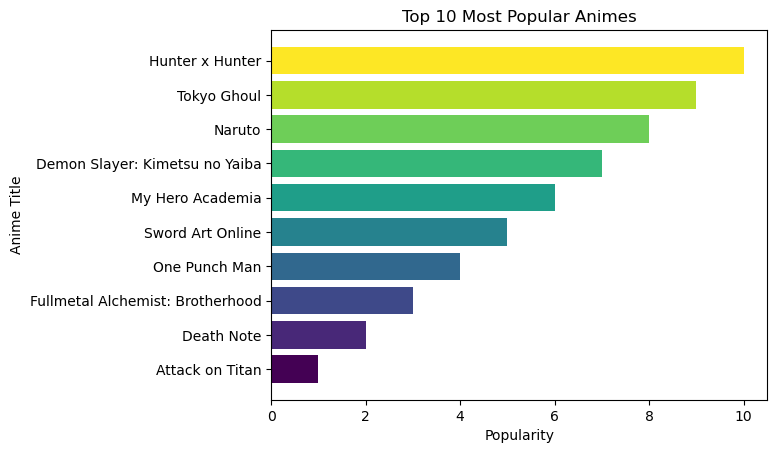

In [39]:
# Vizualization
# Create unique colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10)))

# Create a bar chart with different colors for each bar
plt.barh(top_10['English name'], top_10['Popularity'], color=colors)
plt.xlabel('Popularity')
plt.ylabel('Anime Title')
plt.title('Top 10 Most Popular Animes')

plt.show()

In [40]:
# Next, let's look at the categories of anime
genre_counts = clean_anime_df['Genres'].apply(lambda x: x.split(', ')).explode().value_counts()
print(genre_counts)

Genres
Comedy           7142
Fantasy          5306
UNKNOWN          4929
Action           4730
Adventure        3842
Sci-Fi           3091
Drama            2836
Romance          2063
Slice of Life    1755
Supernatural     1494
Hentai           1486
Mystery           847
Avant Garde       804
Ecchi             795
Sports            771
Horror            534
Suspense          242
Award Winning     241
Boys Love         169
Gourmet           146
Girls Love        113
Erotica            54
Name: count, dtype: int64


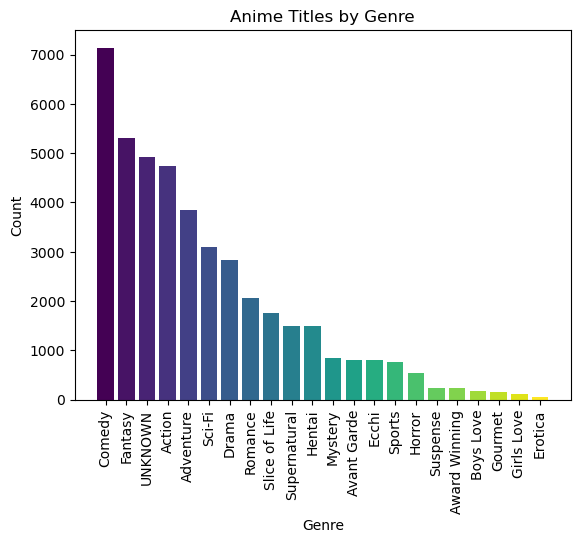

In [41]:
# Visualization
# Create unique colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(genre_counts)))

# Create a bar chart
plt.bar(genre_counts.index, genre_counts.values, color=colors)

# Label the axes and add a title
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Anime Titles by Genre')
plt.xticks(rotation=90)

plt.show()


In [42]:
# Number of anime titles by type
print(clean_anime_df.groupby('Type').size())

Type
Movie      4381
Music      2686
ONA        3533
OVA        4076
Special    2558
TV         7597
UNKNOWN      74
dtype: int64


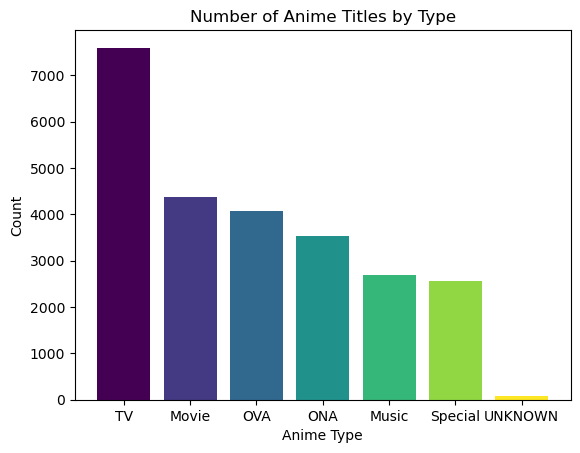

In [43]:
# Visualization
# Count the number of anime titles by type
anime_types = clean_anime_df['Type'].value_counts()

# Create unique colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(anime_types)))

# Create a bar chart
plt.bar(anime_types.index, anime_types.values, color=colors)

# Set the labels and title
plt.xlabel('Anime Type')
plt.ylabel('Count')
plt.title('Number of Anime Titles by Type')

# Display the plot
plt.show()

# Data Pre-processing

In [44]:
def encode_genres(clean_anime_df):
    # Split the 'Genres' column
    clean_anime_df['Genres'] = clean_anime_df['Genres'].str.split(', ')

    # Use MultiLabelBinarizer to one-hot encode the genres
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(clean_anime_df['Genres'])

    # Convert the encoded genres to a DataFrame and set column names
    genres_encoded_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

    # Concatenate the encoded genres to the original dataframe
    clean_anime_df = pd.concat([clean_anime_df, genres_encoded_df], axis=1)

    # Drop the original 'Genres' column
    clean_anime_df.drop('Genres', axis=1, inplace=True)
    
    return clean_anime_df

clean_anime_df = encode_genres(clean_anime_df)

In [45]:
clean_anime_df.head(3)

,anime_id,English name,Synopsis,Type,Rank,Popularity,Image URL,Action,Adventure,Avant Garde,...,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense,UNKNOWN
0,1,Cowboy Bebop,"Crime is timeless. By the year 2071, humanity ...",TV,41.0,43,https://www.otakucastle.com/anime_img/cowboy_b...,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,5,Cowboy Bebop: The Movie,"Another day, another bounty—such is the life o...",Movie,189.0,602,https://www.otakucastle.com/anime_img/cowboy_b...,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,6,Trigun,"Vash the Stampede is the man with a $$60,000,0...",TV,328.0,246,https://www.otakucastle.com/anime_img/trigun.jpg,1,1,0,...,0,0,0,0,1,0,0,0,0,0


In [46]:
# Merge the dataframes on 'anime_id'
combined_df = pd.merge(clean_scores_df, clean_anime_df, on='anime_id', how='left')

In [47]:
combined_df.head(3)

,user_id,anime_id,rating,English name,Synopsis,Type,Rank,Popularity,Image URL,Action,...,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense,UNKNOWN
0,1,21,9,One Piece,"Gol D. Roger was known as the ""Pirate King,"" t...",TV,55.0,20.0,https://www.otakucastle.com/anime_img/one_piec...,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,48,7,.hack//Sign,"A young wavemaster, only known by the alias of...",TV,4172.0,1243.0,https://www.otakucastle.com/anime_img/hack__si...,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,320,5,Kite,"After her parents were brutally murdered, scho...",OVA,0.0,2485.0,https://www.otakucastle.com/anime_img/kite.jpg,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24325191 entries, 0 to 24325190
Data columns (total 31 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   anime_id       int64  
 2   rating         int64  
 3   English name   object 
 4   Synopsis       object 
 5   Type           object 
 6   Rank           float64
 7   Popularity     float64
 8   Image URL      object 
 9   Action         float64
 10  Adventure      float64
 11  Avant Garde    float64
 12  Award Winning  float64
 13  Boys Love      float64
 14  Comedy         float64
 15  Drama          float64
 16  Ecchi          float64
 17  Erotica        float64
 18  Fantasy        float64
 19  Girls Love     float64
 20  Gourmet        float64
 21  Hentai         float64
 22  Horror         float64
 23  Mystery        float64
 24  Romance        float64
 25  Sci-Fi         float64
 26  Slice of Life  float64
 27  Sports         float64
 28  Supernatural   float64
 29  Suspense    

In [49]:
# Number of unique users and animes
num_users = combined_df['user_id'].nunique()
num_animes = combined_df['anime_id'].nunique()
print("Users: ", num_users)
print("Anime: ", num_animes)

Users:  270033
Anime:  16500


In [50]:
combined_df['user_id'] = combined_df['user_id'].astype("category").cat.codes
combined_df['anime_id'] = combined_df['anime_id'].astype("category").cat.codes

In [51]:
print("Max User ID:", combined_df['user_id'].max())
print("Min User ID:", combined_df['user_id'].min())
print("Max Anime ID:", combined_df['anime_id'].max())
print("Min Anime ID:", combined_df['anime_id'].min())

Max User ID: 270032
Min User ID: 0
Max Anime ID: 16499
Min Anime ID: 0


In putting together the Flask file to run the recommender system on a website, I have found that several changes need to be made to the combined_df file to reduce it's size and complexity. Further, I also need to separate the PyTorch section into it's own file. Below was originally the implementation of the machine learning model: PyTorch using a Neural Collaborative Filtering (NCF) approach to train and model the data. I am moving this section to a new file: model.py. It can be found in the repository, and is described in the README.md.

In [52]:
# Write new combined dataset to csv
combined_df.to_csv('combined_dataset.csv')